In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.nonparametric import kaplan_meier_estimator
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

## 01 Descriptif_patients

In [107]:
data_patient = pd.read_excel('./data/Descriptif_patients.xlsx')
print(data_patient.head())

c:\Users\wangy\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Cell M28 is marked as a date but the serial value 6684731 is outside the limits for dates. The cell will be treated as an error.
  for idx, row in parser.parse():


  classe_name  patient_num Gender  Age_at_disease Date_of_MRI Date_of_surgery  \
0         CCK           10      M            62.0  2015-06-30      2015-07-01   
1         CCK           11      F            57.0  2015-05-22      2015-08-12   
2         CCK           12      M            58.0  2016-02-15      2016-04-13   
3         CCK           13      M            65.0  2016-06-07      2016-08-05   
4         CCK           14      M            64.0  2016-10-26      2017-03-16   

   Alpha_foetoprotein  Local_relapse Date_of_local_relapse  Distant_relapse  \
0                 NaN            0.0                   NaT              0.0   
1                 6.1            0.0                   NaT              0.0   
2                 1.4            NaN                   NaT              1.0   
3                 0.0            0.0                   NaT              1.0   
4                 0.0            0.0                   NaT              0.0   

  Date_of_distant_relapse  Death Date_

In [108]:
data_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   classe_name              147 non-null    object        
 1   patient_num              147 non-null    int64         
 2   Gender                   145 non-null    object        
 3   Age_at_disease           142 non-null    float64       
 4   Date_of_MRI              145 non-null    datetime64[ns]
 5   Date_of_surgery          132 non-null    datetime64[ns]
 6   Alpha_foetoprotein       113 non-null    float64       
 7   Local_relapse            121 non-null    float64       
 8   Date_of_local_relapse    48 non-null     datetime64[ns]
 9   Distant_relapse          122 non-null    float64       
 10  Date_of_distant_relapse  36 non-null     datetime64[ns]
 11  Death                    129 non-null    float64       
 12  Date_of_death            52 non-null

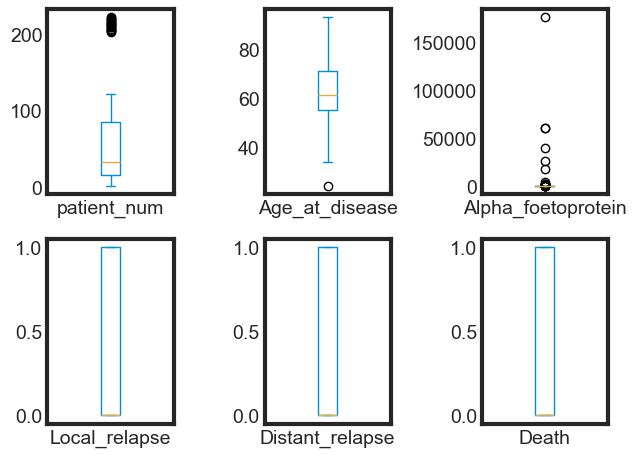

In [109]:
data_patient.plot(kind='box', subplots=True, layout=(2, 3), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

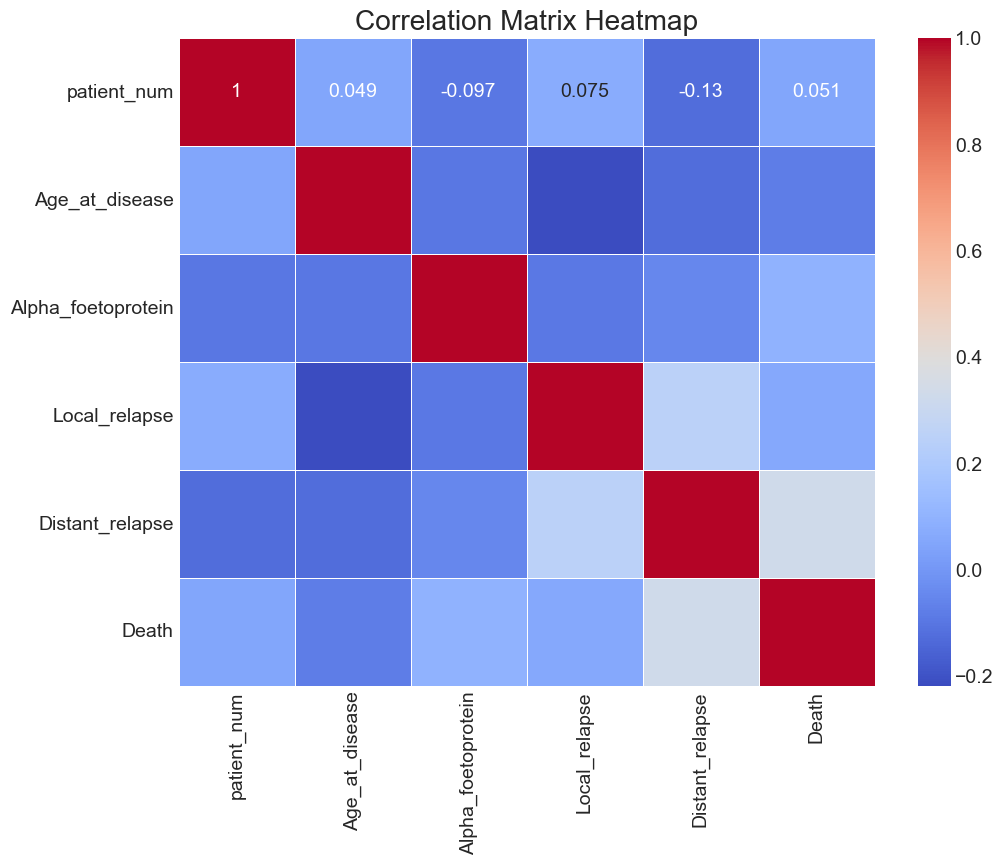

In [110]:
numeric_data_patient = data_patient.select_dtypes(include=[float, int])
correlation_matrix = numeric_data_patient.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### death time analysis

In [111]:
def survival_time_calculation(row):
    today = pd.Timestamp('2024-06-03')
    if row['Death'] is False:
        if pd.isna(row['Date_of_lost_of_FU']):
            return today - row['Date_of_MRI']
        else:
            return row['Date_of_lost_of_FU'] - row['Date_of_MRI']
    else:
        return row['Date_of_death'] - row['Date_of_MRI']
        

In [112]:
df = data_patient.copy()
df['Death'] = df.apply(
    lambda row: True if row['Death'] == 1 else (False if row['Death'] == 0 else row['Death']),
    axis=1
)
df['Death'] = df['Death'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   classe_name              147 non-null    object        
 1   patient_num              147 non-null    int64         
 2   Gender                   145 non-null    object        
 3   Age_at_disease           142 non-null    float64       
 4   Date_of_MRI              145 non-null    datetime64[ns]
 5   Date_of_surgery          132 non-null    datetime64[ns]
 6   Alpha_foetoprotein       113 non-null    float64       
 7   Local_relapse            121 non-null    float64       
 8   Date_of_local_relapse    48 non-null     datetime64[ns]
 9   Distant_relapse          122 non-null    float64       
 10  Date_of_distant_relapse  36 non-null     datetime64[ns]
 11  Death                    147 non-null    bool          
 12  Date_of_death            52 non-null

In [113]:
# Calculate survival time
df['survival_time'] = df.apply(survival_time_calculation, axis=1)
df['survival_time'] = df['survival_time'].dt.days
df_s_t = df.dropna(subset=['Date_of_MRI','Death','survival_time'])
df_s_t.head()

,classe_name,patient_num,Gender,Age_at_disease,Date_of_MRI,Date_of_surgery,Alpha_foetoprotein,Local_relapse,Date_of_local_relapse,Distant_relapse,Date_of_distant_relapse,Death,Date_of_death,Date_of_lost_of_FU,survival_time
0,CCK,10,M,62.0,2015-06-30,2015-07-01,NaN,0.0,NaT,0.0,NaT,True,2015-11-11,NaT,134.0
1,CCK,11,F,57.0,2015-05-22,2015-08-12,6.1,0.0,NaT,0.0,NaT,False,NaT,2017-06-08,748.0
2,CCK,12,M,58.0,2016-02-15,2016-04-13,1.4,NaN,NaT,1.0,2016-06-16,True,2021-03-30,NaT,1870.0
3,CCK,13,M,65.0,2016-06-07,2016-08-05,0.0,0.0,NaT,1.0,2017-06-19,True,2022-04-25,NaT,2148.0
4,CCK,14,M,64.0,2016-10-26,2017-03-16,0.0,0.0,NaT,0.0,NaT,True,2017-03-27,NaT,152.0


Text(0.5, 0, 'time $t$')

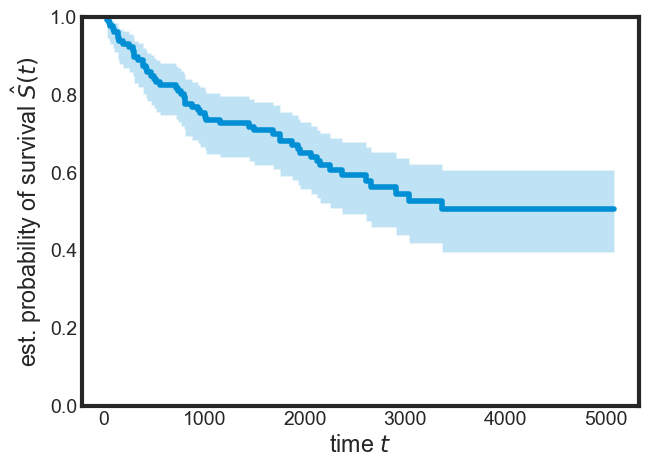

In [114]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    df_s_t['Death'], df_s_t['survival_time'], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

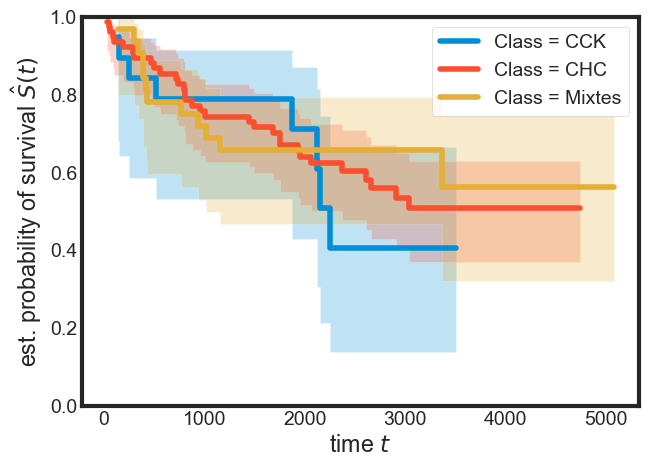

In [115]:
for class_name in ("CCK", "CHC", "Mixtes"):
    mask_class = df["classe_name"] == class_name
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        df_s_t['Death'][mask_class],
        df_s_t['survival_time'][mask_class],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Class = {class_name}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

### local relapse

In [116]:
def l_relapse_time_calculation(row):
    today = pd.Timestamp('2024-06-03')
    if row['Local_relapse'] is False:
        if pd.isna(row['Date_of_lost_of_FU']):
            return today - row['Date_of_MRI']
        else:
            return row['Date_of_lost_of_FU'] - row['Date_of_MRI']
    else:
        return row['Date_of_local_relapse'] - row['Date_of_MRI']

In [117]:
df['Local_relapse'] = df.apply(
    lambda row: True if row['Local_relapse'] == 1 else (False if row['Local_relapse'] == 0 else row['Local_relapse']),
    axis=1
)
df['Local_relapse'] = df['Local_relapse'].astype(bool)
df['local_relapse_time'] = df.apply(l_relapse_time_calculation, axis=1)
df['local_relapse_time'] = df['local_relapse_time'].dt.days
df_l_r = df.dropna(subset=['Date_of_MRI','Local_relapse','local_relapse_time'])

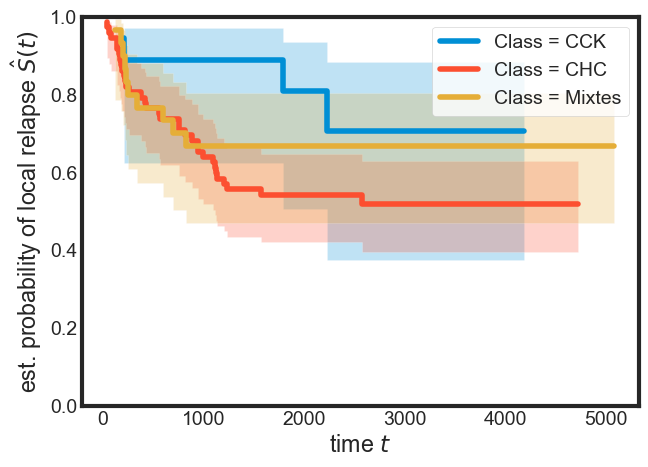

In [118]:
for class_name in ("CCK", "CHC", "Mixtes"):
    mask_class = df_l_r["classe_name"] == class_name
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        df_l_r['Local_relapse'][mask_class],
        df_l_r['local_relapse_time'][mask_class],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Class = {class_name}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of local relapse $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

### distant relapse

In [119]:
def d_relapse_time_calculation(row):
    today = pd.Timestamp('2024-06-03')
    if row['Distant_relapse'] is False:
        if pd.isna(row['Date_of_lost_of_FU']):
            return today - row['Date_of_MRI']
        else:
            return row['Date_of_lost_of_FU'] - row['Date_of_MRI']
    else:
        return row['Date_of_distant_relapse'] - row['Date_of_MRI']

In [120]:
df['Distant_relapse'] = df.apply(
    lambda row: True if row['Distant_relapse'] == 1 else (False if row['Distant_relapse'] == 0 else row['Distant_relapse']),
    axis=1
)
df['Distant_relapse'] = df['Distant_relapse'].astype(bool)
df['distant_relapse_time'] = df.apply(l_relapse_time_calculation, axis=1)
df['distant_relapse_time'] = df['distant_relapse_time'].dt.days
df_d_r = df.dropna(subset=['Date_of_MRI','Distant_relapse','distant_relapse_time'])

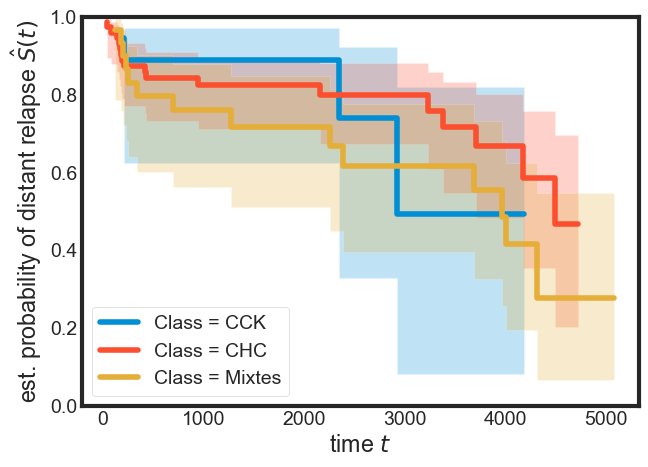

In [121]:
for class_name in ("CCK", "CHC", "Mixtes"):
    mask_class = df["classe_name"] == class_name
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        df_d_r['Distant_relapse'][mask_class],
        df_d_r['distant_relapse_time'][mask_class],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Class = {class_name}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of distant relapse $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [122]:
df.head()

,classe_name,patient_num,Gender,Age_at_disease,Date_of_MRI,Date_of_surgery,Alpha_foetoprotein,Local_relapse,Date_of_local_relapse,Distant_relapse,Date_of_distant_relapse,Death,Date_of_death,Date_of_lost_of_FU,survival_time,local_relapse_time,distant_relapse_time
0,CCK,10,M,62.0,2015-06-30,2015-07-01,NaN,False,NaT,False,NaT,True,2015-11-11,NaT,134.0,3261.0,3261.0
1,CCK,11,F,57.0,2015-05-22,2015-08-12,6.1,False,NaT,False,NaT,False,NaT,2017-06-08,748.0,748.0,748.0
2,CCK,12,M,58.0,2016-02-15,2016-04-13,1.4,True,NaT,True,2016-06-16,True,2021-03-30,NaT,1870.0,NaN,NaN
3,CCK,13,M,65.0,2016-06-07,2016-08-05,0.0,False,NaT,True,2017-06-19,True,2022-04-25,NaT,2148.0,2918.0,2918.0
4,CCK,14,M,64.0,2016-10-26,2017-03-16,0.0,False,NaT,False,NaT,True,2017-03-27,NaT,152.0,2777.0,2777.0


## 02 radiomiques_global

In [123]:
data_global = pd.read_excel('./data/radiomiques_global.xlsx')
print(data_global.head())

  classe_name temps_inj  patient_num  original_firstorder_10Percentile  \
0      Mixtes      VEIN            9                             175.0   
1      Mixtes      TARD            9                             156.0   
2      Mixtes      PORT            9                             174.0   
3      Mixtes       ART            9                             180.7   
4      Mixtes      VEIN            8                             130.0   

   original_firstorder_90Percentile  original_firstorder_Energy  \
0                             324.0                 354376998.0   
1                             271.0                 277383044.0   
2                             289.0                 297110913.0   
3                             416.3                 553036349.0   
4                             148.1                   1189941.0   

   original_firstorder_Entropy  original_firstorder_InterquartileRange  \
0                     3.013456                                   74.00   
1   

In [124]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Columns: 148 entries, classe_name to original_ngtdm_Strength
dtypes: datetime64[ns](3), float64(136), int64(2), object(7)
memory usage: 636.1+ KB


c:\Users\wangy\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


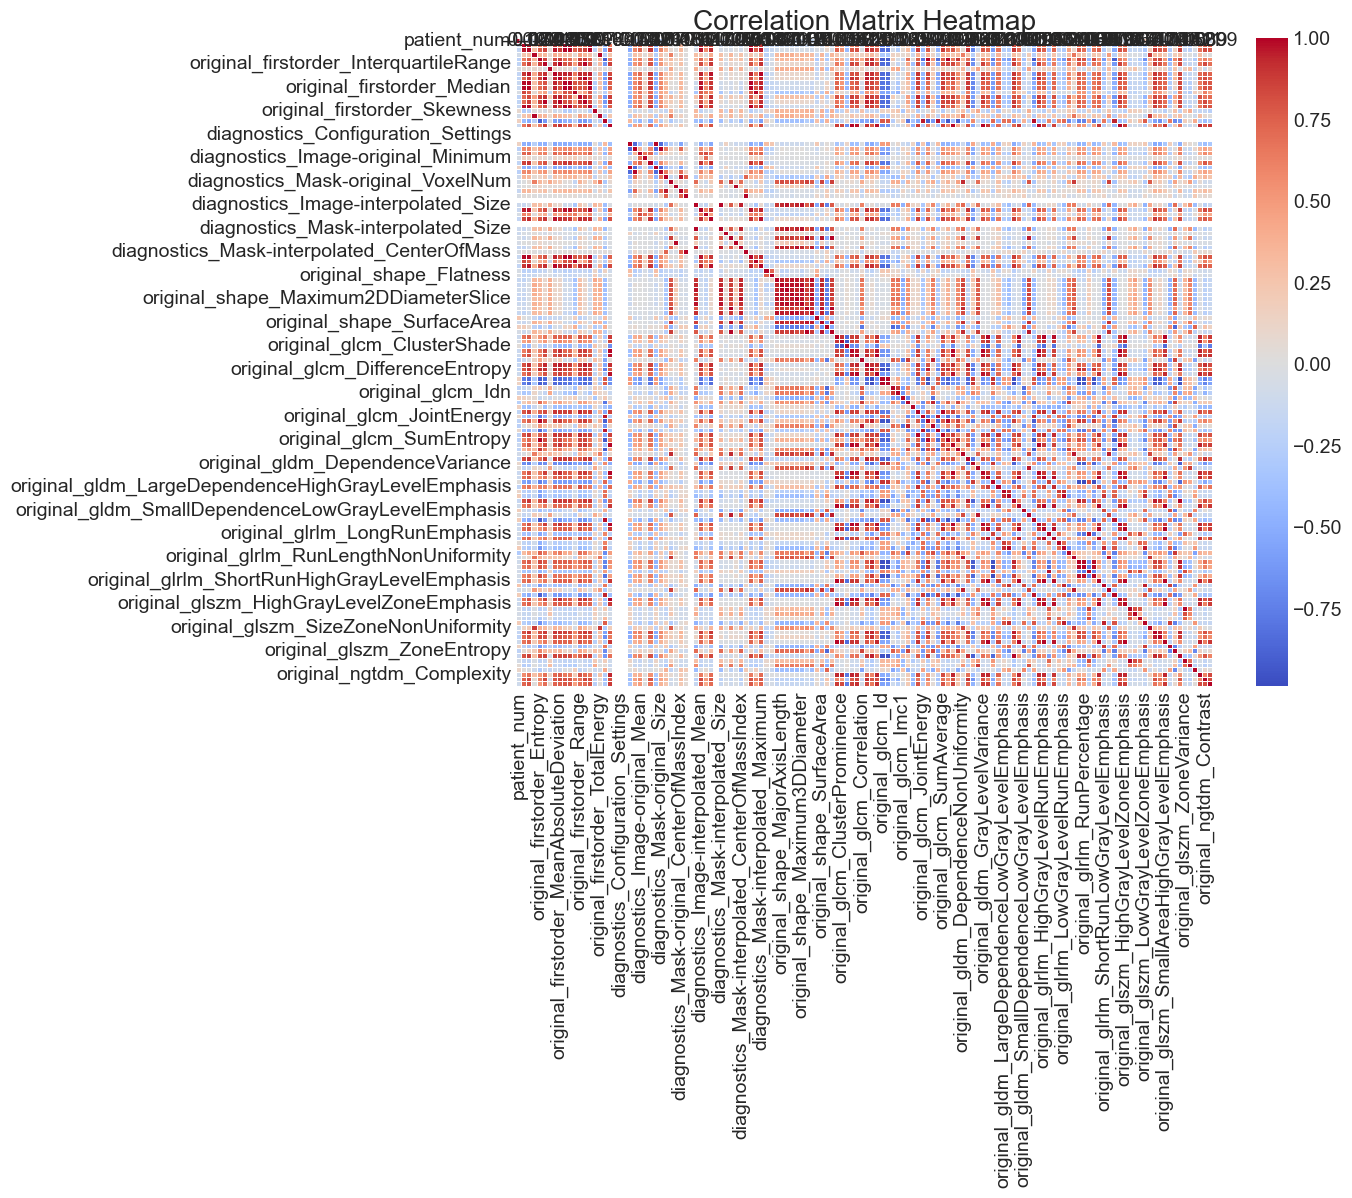

In [125]:
numeric_data_global = data_global.select_dtypes(include=[float, int])
correlation_matrix = numeric_data_global.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [126]:
non_numeric_data = data_global.select_dtypes(exclude=[float, int])
non_numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   classe_name                                550 non-null    object        
 1   temps_inj                                  550 non-null    object        
 2   diagnostics_Versions_PyRadiomics           550 non-null    object        
 3   diagnostics_Versions_Numpy                 550 non-null    object        
 4   diagnostics_Versions_SimpleITK             550 non-null    datetime64[ns]
 5   diagnostics_Versions_PyWavelet             550 non-null    datetime64[ns]
 6   diagnostics_Versions_Python                550 non-null    datetime64[ns]
 7   diagnostics_Image-original_Hash            550 non-null    object        
 8   diagnostics_Image-original_Dimensionality  550 non-null    object        
 9   diagnostics_Mask-orig

### Feature Selection

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   classe_name              147 non-null    object        
 1   patient_num              147 non-null    int64         
 2   Gender                   145 non-null    object        
 3   Age_at_disease           142 non-null    float64       
 4   Date_of_MRI              145 non-null    datetime64[ns]
 5   Date_of_surgery          132 non-null    datetime64[ns]
 6   Alpha_foetoprotein       113 non-null    float64       
 7   Local_relapse            147 non-null    bool          
 8   Date_of_local_relapse    48 non-null     datetime64[ns]
 9   Distant_relapse          147 non-null    bool          
 10  Date_of_distant_relapse  36 non-null     datetime64[ns]
 11  Death                    147 non-null    bool          
 12  Date_of_death            52 non-null

In [128]:
classe_name_map = {'CHC': 1, 'CCK': 2, 'Mixtes': 0}
gender_map = {'M': 0, 'F': 1}
df['classe_name'] = df['classe_name'].map(classe_name_map)
df['Gender'] = df['Gender'].map(gender_map)
df['Local_relapse'] = df['Local_relapse'].astype(int)
df['Distant_relapse'] = df['Distant_relapse'].astype(int)
df['Death'] = df['Death'].astype(int)
df.head()

,classe_name,patient_num,Gender,Age_at_disease,Date_of_MRI,Date_of_surgery,Alpha_foetoprotein,Local_relapse,Date_of_local_relapse,Distant_relapse,Date_of_distant_relapse,Death,Date_of_death,Date_of_lost_of_FU,survival_time,local_relapse_time,distant_relapse_time
0,2,10,0.0,62.0,2015-06-30,2015-07-01,NaN,0,NaT,0,NaT,1,2015-11-11,NaT,134.0,3261.0,3261.0
1,2,11,1.0,57.0,2015-05-22,2015-08-12,6.1,0,NaT,0,NaT,0,NaT,2017-06-08,748.0,748.0,748.0
2,2,12,0.0,58.0,2016-02-15,2016-04-13,1.4,1,NaT,1,2016-06-16,1,2021-03-30,NaT,1870.0,NaN,NaN
3,2,13,0.0,65.0,2016-06-07,2016-08-05,0.0,0,NaT,1,2017-06-19,1,2022-04-25,NaT,2148.0,2918.0,2918.0
4,2,14,0.0,64.0,2016-10-26,2017-03-16,0.0,0,NaT,0,NaT,1,2017-03-27,NaT,152.0,2777.0,2777.0


In [129]:
df.info()
complete_dataset = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   classe_name              147 non-null    int64         
 1   patient_num              147 non-null    int64         
 2   Gender                   145 non-null    float64       
 3   Age_at_disease           142 non-null    float64       
 4   Date_of_MRI              145 non-null    datetime64[ns]
 5   Date_of_surgery          132 non-null    datetime64[ns]
 6   Alpha_foetoprotein       113 non-null    float64       
 7   Local_relapse            147 non-null    int32         
 8   Date_of_local_relapse    48 non-null     datetime64[ns]
 9   Distant_relapse          147 non-null    int32         
 10  Date_of_distant_relapse  36 non-null     datetime64[ns]
 11  Death                    147 non-null    int32         
 12  Date_of_death            52 non-null

In [130]:
df_numeric = df.select_dtypes(include=['int64', 'float64','int32'])
df_numeric = df_numeric.astype('float64')
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   classe_name           147 non-null    float64
 1   patient_num           147 non-null    float64
 2   Gender                145 non-null    float64
 3   Age_at_disease        142 non-null    float64
 4   Alpha_foetoprotein    113 non-null    float64
 5   Local_relapse         147 non-null    float64
 6   Distant_relapse       147 non-null    float64
 7   Death                 147 non-null    float64
 8   survival_time         128 non-null    float64
 9   local_relapse_time    121 non-null    float64
 10  distant_relapse_time  121 non-null    float64
dtypes: float64(11)
memory usage: 12.8 KB


In [131]:
df_numeric = df_numeric.fillna(df_numeric.mean())

In [137]:
X = df_numeric.drop(columns=['classe_name', 'patient_num'])
y = df_numeric['classe_name']
#apply SelectKBest class to extract top 10 best features
kbest = SelectKBest(score_func=chi2, k=9)
fit = kbest.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
fScores = pd.concat([df_columns,df_scores],axis=1)
fScores.columns = ['Feature','Score']  #naming the dataframe columns
print(fScores.nlargest(10,'Score')) 
#print 10 best features

                Feature          Score
2    Alpha_foetoprotein  116236.549216
6         survival_time    1916.961849
7    local_relapse_time     495.541488
8  distant_relapse_time     495.541488
0                Gender       6.731895
4       Distant_relapse       2.515865
1        Age_at_disease       1.664091
3         Local_relapse       1.119599
5                 Death       0.113926


c:\Users\wangy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


[Text(0.5, 0, 'Feature'), Text(0, 0.5, 'Importance')]

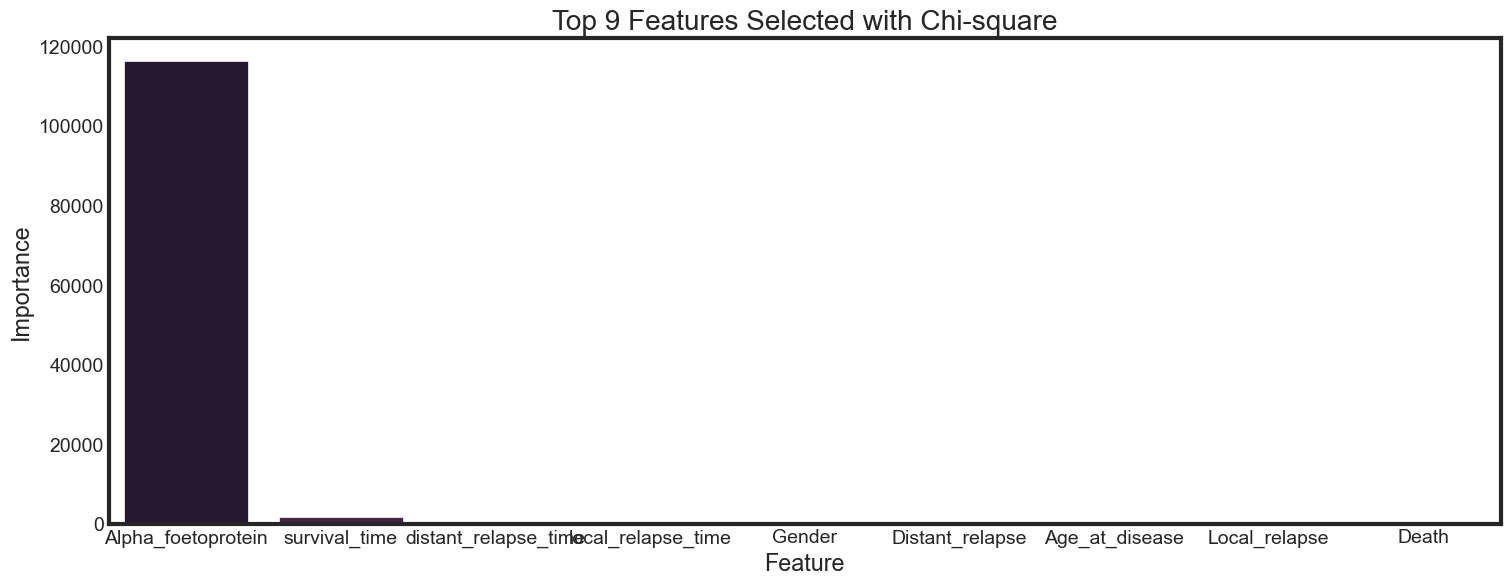

In [140]:
indices = np.argsort(kbest.scores_)[::-1]

features = []
for i in range(9):
    features.append(X.columns[indices[i]])

fig, ax = plt.subplots(figsize=(16,6))     
sns.barplot(x=features, y=kbest.scores_[indices[range(9)]],\
            label="Importtant Categorical Features", palette=("rocket"),ax=ax).set_title('Top 9 Features Selected with Chi-square')
ax.set(xlabel="Feature", ylabel = "Importance")

 Feature                  Score
Alpha_foetoprotein      0.309762
Age_at_disease          0.241148
survival_time           0.168108
Gender                  0.107127
distant_relapse_time    0.046746
local_relapse_time      0.042777
Distant_relapse         0.039370
Local_relapse           0.036207
Death                   0.008754
dtype: float64


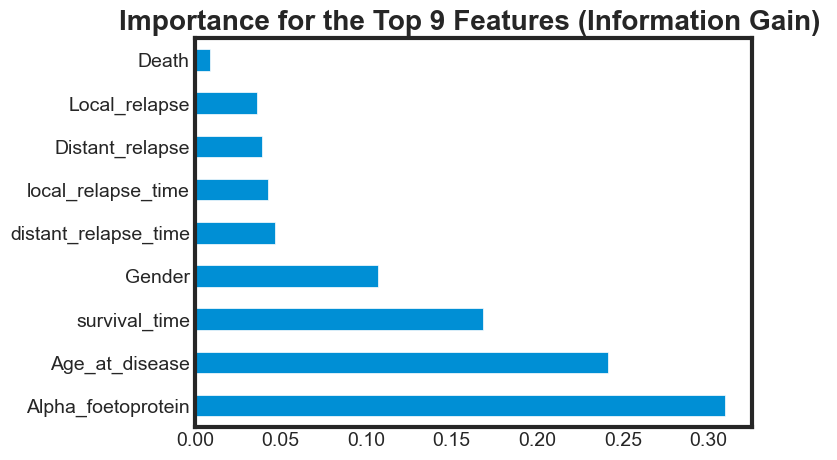

In [141]:
#Information Gain

#the model possesses tuned hyperparameter
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=20, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False)
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
imp_feat = feat_importances.nlargest(9)
print(" Feature                  Score")
print(imp_feat)

# determine 20 most important features
imp_feat = feat_importances.nlargest(9)
plt.title(f'Importance for the Top 9 Features (Information Gain) ', fontweight='bold')
imp_feat.plot(kind='barh')
plt.show()

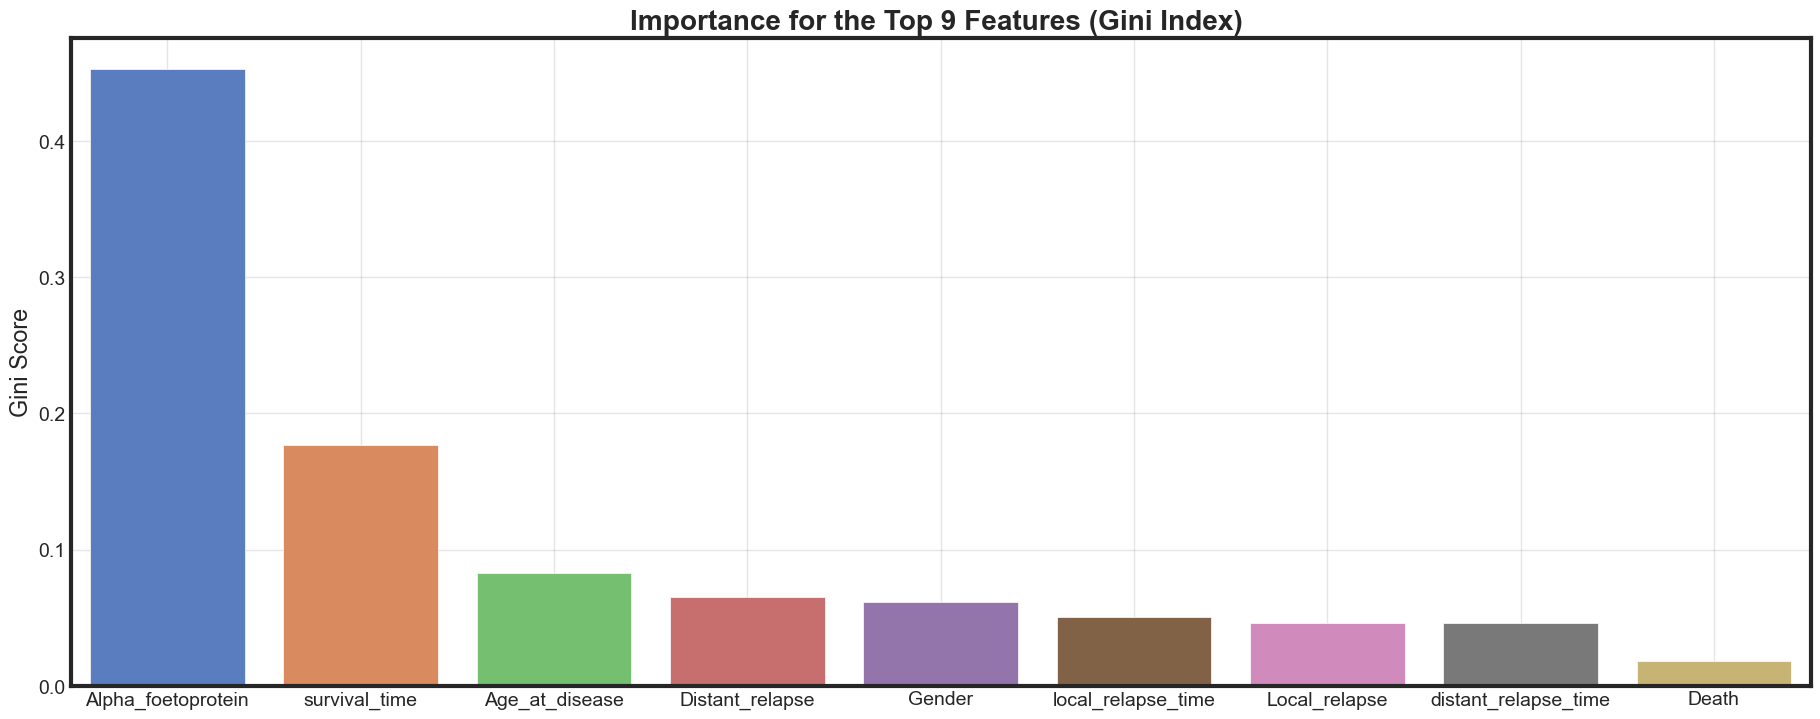

In [142]:
#Gini Index

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                               max_features=9, min_samples_leaf=20,
                               min_samples_split=20, n_estimators=600, random_state= None)
model.fit(X,y)


feature_importance = {}
best_estimator_fi = model.feature_importances_

for feature, importance in zip(X.columns, best_estimator_fi):
    feature_importance[feature] = importance

f_importances = pd.DataFrame.from_dict(feature_importance, orient='index').rename(columns={0: 'Gini Score'})
importances = f_importances.sort_values(by='Gini Score', ascending=False)


# Plot for feature importance
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
sns.set_style("white")
sns.barplot(x=importances.index[0:9], y=importances['Gini Score'].iloc[0:9], palette='muted')
plt.title(f'Importance for the Top 9 Features (Gini Index) ', fontweight='bold')
plt.grid(True, alpha=0.1, color='black')
plt.show()